# MODULO 5

Regresion y Clasificación con scikit-learn

## IMPORTAR LIBRERIAS

In [33]:
# Librerias principales

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Preprocesados

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, OneHotEncoder, LabelEncoder

# Imputadores

from sklearn.impute import SimpleImputer, KNNImputer

# Regresion y Clasificacion

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC

# Metricas

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, recall_score

#Pipelines

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Validacion Cruzada

from sklearn.model_selection import cross_validate 

## CARGA DE DATOS Y PRIMERAS COMPROBACIONES

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")
df.drop(['name','id', 'host_id', 'host_name','last_review'], axis=1, inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Despues de cargar los datos con los que vamos a trabajar en el ejercicio vamos a comprobar si tiene valores nulos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


Tenemos 10052 nulos en reviews per month

## Primeros EDAS

Como queremos hacer una regresión que prediga el precio del alojamiento y una clasificación para calcular el room_type voy a hacer unos EDAS en torno a esas variables para ver que me muestran

### Histograma Precios

<Axes: xlabel='price', ylabel='Count'>

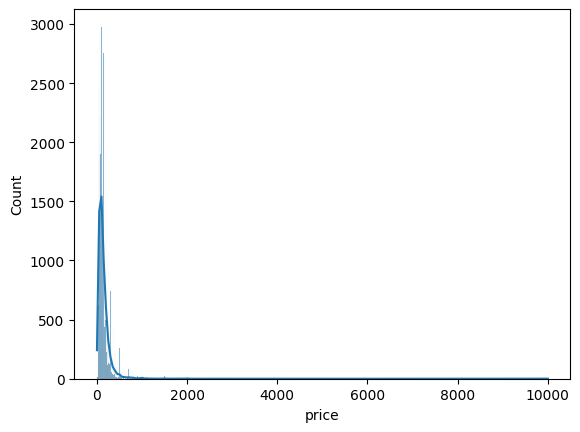

In [4]:
sns.histplot(df, x='price', kde=True)

Podemos ver claramente que hay algun tipo de outlier en esta columna porque el precio se va hasta los 10000$, voy a comprobarlo con un boxplot

### Boxplot precios dividido por tipo de habitación

<Axes: ylabel='price'>

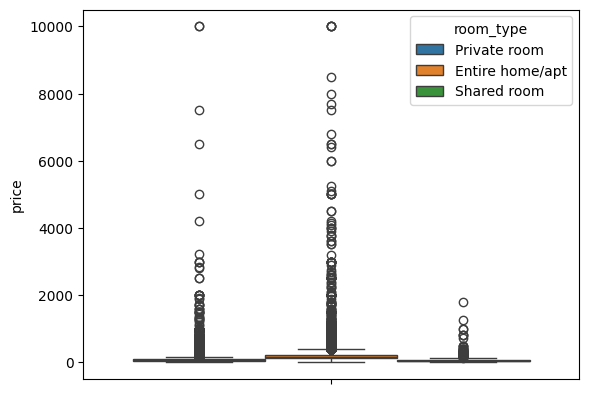

In [5]:
sns.boxplot(df, hue='room_type', y='price')

Confirmo que hay muchos outliers pero como no voy a querer perderlos a la hora de trabajar con los datos voy a realizar una transformación logaritmica que me va a reducir en gran medida los mismos

### Countvalues por Tipo de habitación

<Axes: xlabel='room_type', ylabel='count'>

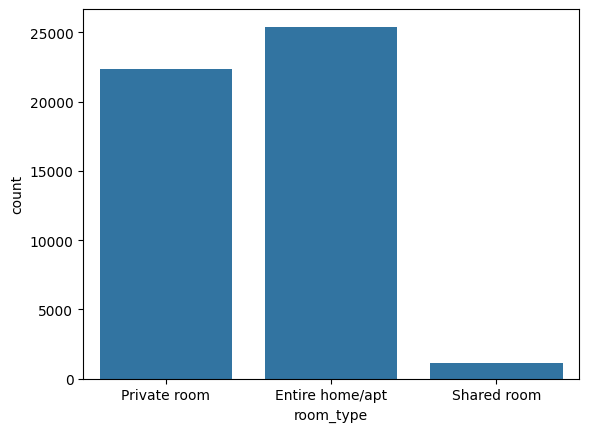

In [6]:
sns.countplot(df, x='room_type')

Como el tipo de habitación Shared hay muy pocos datos comparados con el de los otros 2 tipos de habitación se podria intentar realizar un SMOTE

### Pairplot

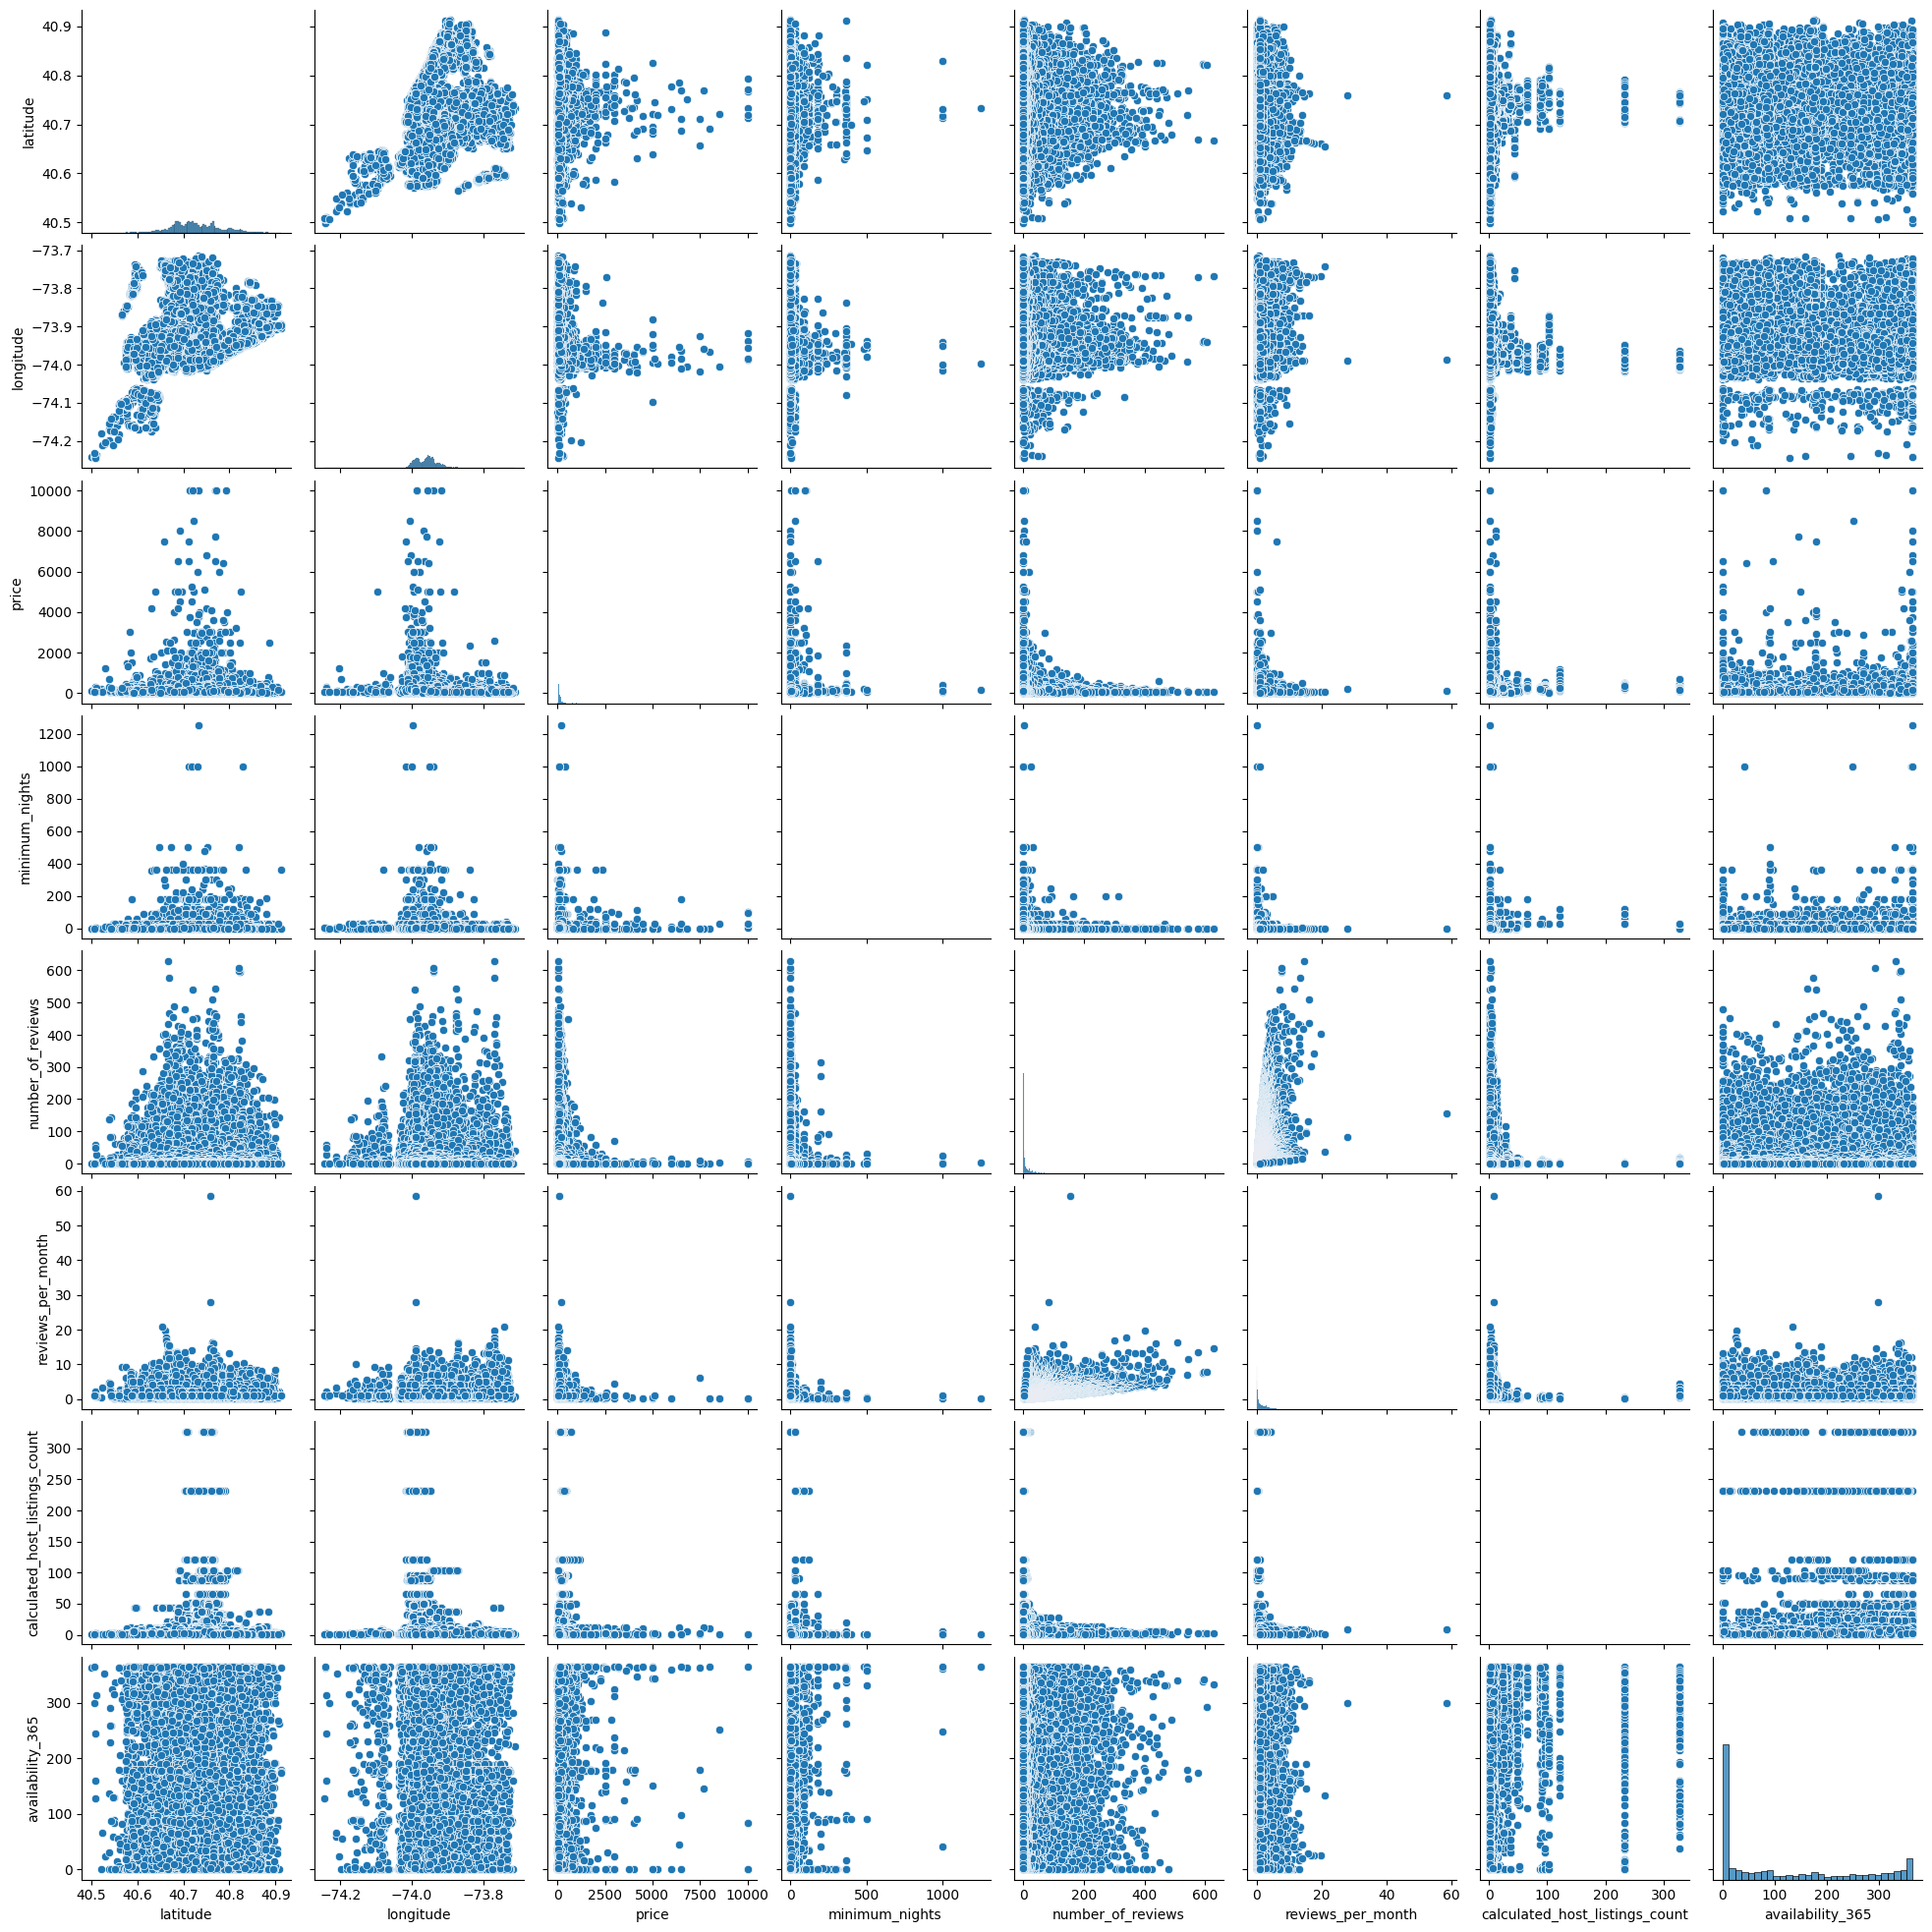

In [7]:
sns.pairplot(df)

Asi de primeras parece que ninguna variable numerica tiene una correlación directa entre si, solo la longitud y la latitud, vamos a comprobarlo ahora con una matriz de correlacion de las variable numericas

### Matriz correlacion variables numericas

<Axes: >

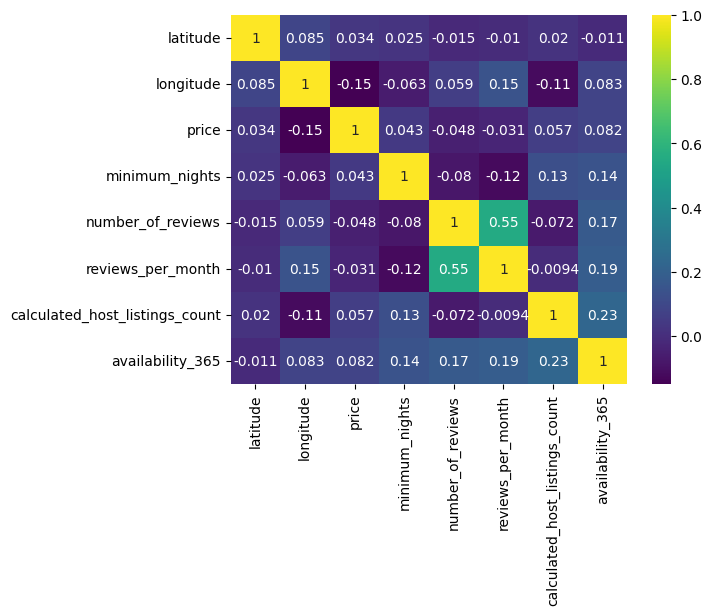

In [8]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')

Como sospechamos anteriormente no hay una relación directa de ninguna de las varibles con el precio supongo que por la cantidad de outliers.

Antes de realizar el entrenamiento y el trabajo con las variables, voy a ver que relación hay en caso transformar logaritmicamente el precio.

Lo hago para comprobar como cambian los datos.

Por eso lo voy a hacer en una copia del dataframe, por que esta copia no es la que vamos a usar en el entrenamiento ni la division de los datos

In [9]:
df2 = df.copy()
df2.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


<Axes: >

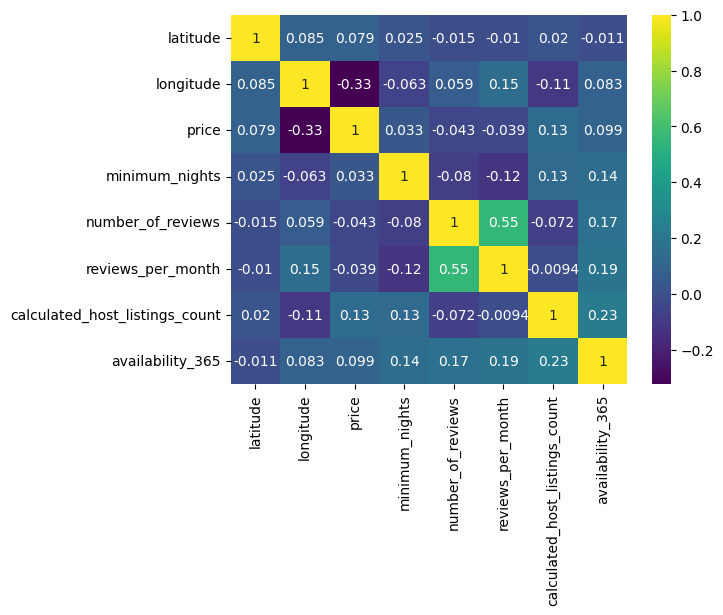

In [10]:
df2['price'] = np.log1p(df2['price'])

sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='viridis')

Se puede ver que ha mejorado un poco la correlacion usando la transformacion logaritmica

## COMPROBACION DE QUE COLUMNAS TIENEN UNA CORRELACION MAYOR A 0.1 O MENOR A -0.1 RESPECTO AL PRECIO

DataFrame original con get dummies en categoricas

([0, 1, 2, 3],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'longitude'),
  Text(3, 0, 'room_type_Private room')])

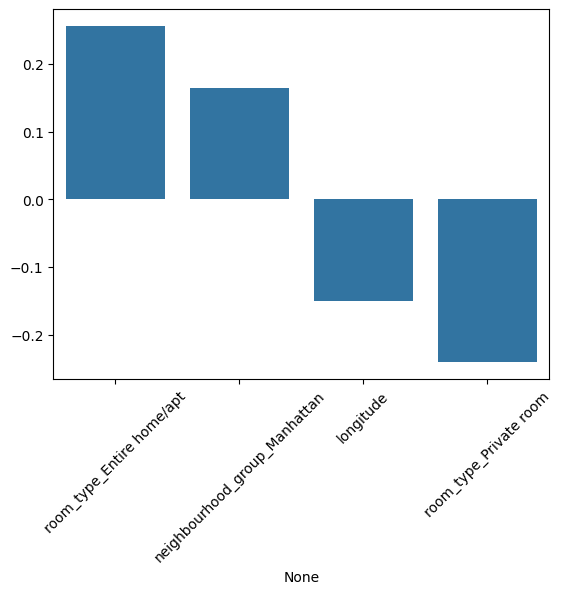

In [11]:
price_correlation=pd.get_dummies(df).corr()['price'].drop(['price'])

#price_correlation
filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=45)

DataFrame original con transformacion logaritmica de precios y con get dummies en categoricas

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'neighbourhood_Midtown'),
  Text(3, 0, 'calculated_host_listings_count'),
  Text(4, 0, 'neighbourhood_Chelsea'),
  Text(5, 0, 'neighbourhood_West Village'),
  Text(6, 0, "neighbourhood_Hell's Kitchen"),
  Text(7, 0, 'neighbourhood_group_Bronx'),
  Text(8, 0, 'neighbourhood_Bedford-Stuyvesant'),
  Text(9, 0, 'neighbourhood_Bushwick'),
  Text(10, 0, 'room_type_Shared room'),
  Text(11, 0, 'neighbourhood_group_Queens'),
  Text(12, 0, 'neighbourhood_group_Brooklyn'),
  Text(13, 0, 'longitude'),
  Text(14, 0, 'room_type_Private room')])

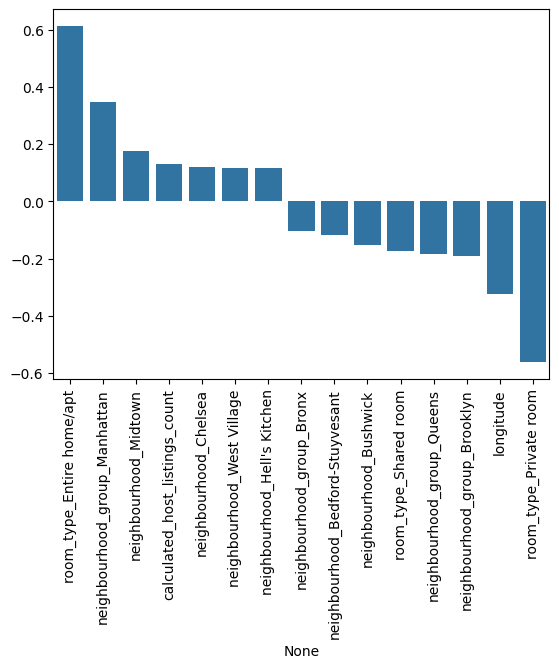

In [12]:
price_correlation=pd.get_dummies(df2).corr()['price'].drop(['price'])

#price_correlation
filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=90)

Observamos que gracias a la transformacion logaritmica hay muchos mas campos que tienen una correlacion absoluta mayor a |0.1|

Pasando de 4 sin transformar a 15 transformadas

Aunque en ningun caso tiene una gran correlacion

## COMPROBACION DE OUTLIERS

<Axes: xlabel='price', ylabel='Count'>

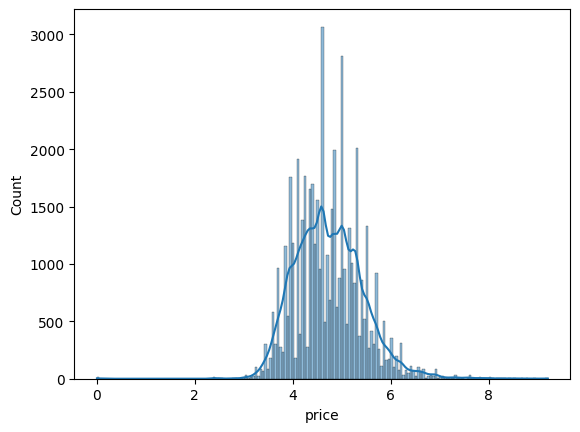

In [13]:
sns.histplot(df2, x='price', kde=True)

<Axes: ylabel='price'>

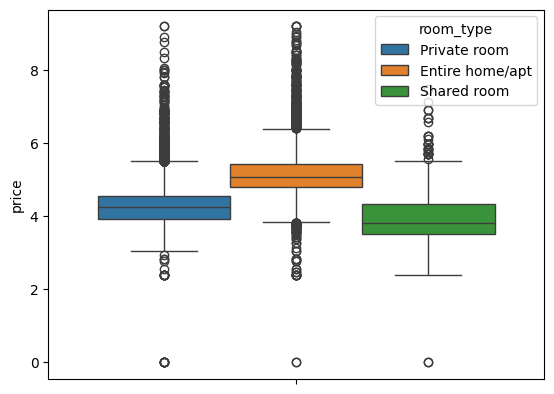

In [14]:
sns.boxplot(df2, y='price', hue='room_type')

Podemos observar que sigue habiendo outliers y vamos a ver cuantos outliers habria en cada uno de los 2 (sin transformar y transformado)

Todavia no he emprezado con los preprocesados ni con el calculo, esto es solo un analisis visual del problema por eso estoy usando getdumies y np.log para realizar transformaciones y todo

### CONTAR OUTLIERS SIN TRANSFORMAR PRECIO

In [15]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = filtro = ~((df['price'] < lower_bound) | (df['price'] > upper_bound))
print(df.shape)
print(df[filtro].shape)
print(f'Filas eliminadas {df.shape[0]-df[filtro].shape[0]} - {round(100*(df.shape[0]-df[filtro].shape[0])/df.shape[0],2)}%')

(48895, 11)
(45923, 11)
Filas eliminadas 2972 - 6.08%


### CONTAR OUTLIERS TRANSFORMANDO PRECIO

In [16]:
Q1 = df2['price'].quantile(0.25)
Q3 = df2['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = filtro = ~((df2['price'] < lower_bound) | (df2['price'] > upper_bound))
print(df2.shape)
print(df2[filtro].shape)
print(f'Filas eliminadas {df2.shape[0]-df2[filtro].shape[0]} - {round(100*(df2.shape[0]-df2[filtro].shape[0])/df2.shape[0],2)}%')

(48895, 11)
(48258, 11)
Filas eliminadas 637 - 1.3%


Podemos comprobrar que la transformacion logaritmica ha convertido en valores validos muchos outliers

### MATRIZ DE CORRELACION SIN TRANSFORMACION DE PRECIO Y SIN CONTAR OUTLIERS

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'neighbourhood_Midtown'),
  Text(3, 0, 'calculated_host_listings_count'),
  Text(4, 0, 'neighbourhood_Chelsea'),
  Text(5, 0, 'neighbourhood_West Village'),
  Text(6, 0, "neighbourhood_Hell's Kitchen"),
  Text(7, 0, 'availability_365'),
  Text(8, 0, 'neighbourhood_Bedford-Stuyvesant'),
  Text(9, 0, 'room_type_Shared room'),
  Text(10, 0, 'neighbourhood_Bushwick'),
  Text(11, 0, 'neighbourhood_group_Queens'),
  Text(12, 0, 'neighbourhood_group_Brooklyn'),
  Text(13, 0, 'longitude'),
  Text(14, 0, 'room_type_Private room')])

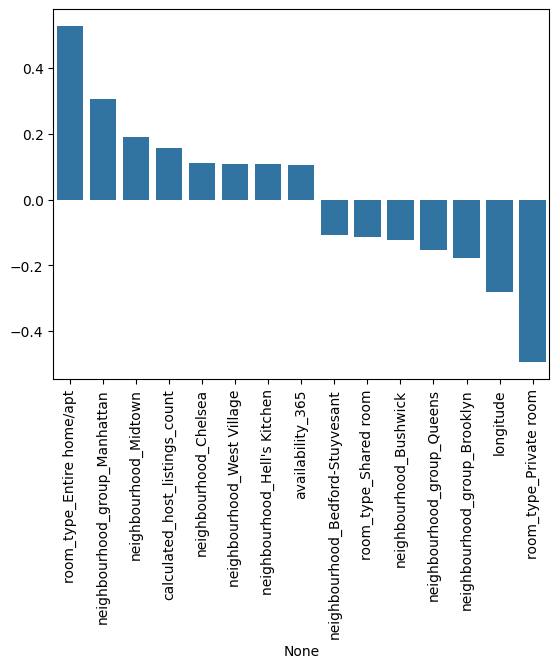

In [17]:
df_ultimo_analisis_previo = df.copy()
df_ultimo_analisis_previo = df_ultimo_analisis_previo[filtro]
price_correlation=pd.get_dummies(df_ultimo_analisis_previo).corr()['price'].drop(['price'])

filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=90)

### MATRIZ DE CORRELACION CON TRANSFORMACION DE PRECIO Y SIN CONTAR OUTLIERS

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'neighbourhood_Midtown'),
  Text(3, 0, 'calculated_host_listings_count'),
  Text(4, 0, "neighbourhood_Hell's Kitchen"),
  Text(5, 0, 'neighbourhood_Chelsea'),
  Text(6, 0, 'neighbourhood_West Village'),
  Text(7, 0, 'neighbourhood_Financial District'),
  Text(8, 0, 'neighbourhood_group_Bronx'),
  Text(9, 0, 'neighbourhood_Bedford-Stuyvesant'),
  Text(10, 0, 'neighbourhood_Bushwick'),
  Text(11, 0, 'room_type_Shared room'),
  Text(12, 0, 'neighbourhood_group_Queens'),
  Text(13, 0, 'neighbourhood_group_Brooklyn'),
  Text(14, 0, 'longitude'),
  Text(15, 0, 'room_type_Private room')])

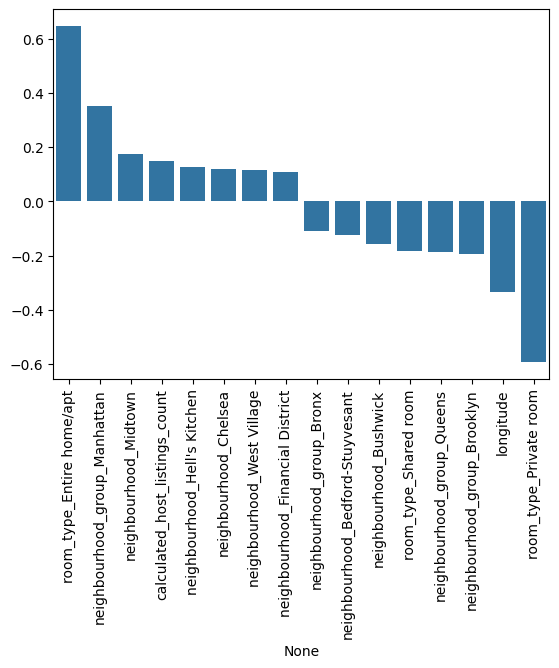

In [18]:
df2_ultimo_analisis_previo = df2.copy()
df2_ultimo_analisis_previo = df2_ultimo_analisis_previo[filtro]
price_correlation=pd.get_dummies(df2_ultimo_analisis_previo).corr()['price'].drop(['price'])

filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=90)

Se puede comprobar que la mejor estrategia es realizar una transformacion logaritmica del precio y no tener en cuenta los outliers asi que vamos a trabajar de ese modo a la hora de realizar nuestro trabajo.

La estrategia a emplear sera la transformacion logistica de Precios y eliminar los outliers

## CARGAR DE NUEVO LOS DATOS NECESARIOS Y EMPEZAR A CON LOS PREPORCESADOS

In [19]:
df = pd.read_csv("AB_NYC_2019.csv")
df.drop(['id', 'host_id', 'host_name','last_review'], axis=1, inplace=True)
names = df['name']
df.drop('name', axis=1, inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


### Transformacion logaritmica del precio

In [20]:
df['price_log'] = np.log1p(df['price'])
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_log
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,5.010635
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,5.420535
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,5.017280
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,4.499810
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,4.394449


### Eliminacion de Outliers del precio

In [21]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = ~((df['price'] < lower_bound) | (df['price'] > upper_bound))

df_o = df[filtro]

Q1 = df['price_log'].quantile(0.25)
Q3 = df['price_log'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = ~((df['price_log'] < lower_bound) | (df['price_log'] > upper_bound))

df_log = df[filtro]

print('original sin outlier: ', df_o.shape)
print('logaritmica sin outlier: ', df_log.shape)

original sin outlier:  (45923, 12)
logaritmica sin outlier:  (48258, 12)


## REGRESION

Nuestras columnas X van a ser todas menos el precio por eso hare un drop de precio y nuestra columna y ser´el precio

Usando Pipelines

In [22]:
X = df_o.drop(['price', 'price_log'], axis=1)
y = df_o['price']

X_log = df_log.drop(['price', 'price_log'], axis=1)
y_log = df_log['price_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.20, random_state=42)

### Separacion entre columnas numericas y categoricas

In [23]:
numerical_col = X_train.select_dtypes(include=[np.number]).columns.to_list()
categorical_col = X_train.select_dtypes(exclude=[np.number]).columns.to_list()

print('Columnas numericas', numerical_col)
print('Columnas categoricas', categorical_col)

Columnas numericas ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Columnas categoricas ['neighbourhood_group', 'neighbourhood', 'room_type']


In [24]:
df_resultados = pd.DataFrame(columns=['Modelo','R2', 'MAE', 'RMSE', 'MAPE'])

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_col),
    ('categorical', pipeline_categorical, categorical_col)
])
pipeline = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', LinearRegression())]
)
pipeline.fit(X_train_log, y_train_log)
y_pred = pipeline.predict(X_test_log)

r2 = r2_score(y_test_log, y_pred)
mae = mean_absolute_error(y_test_log, y_pred)
rmse = root_mean_squared_error(y_test_log, y_pred)
mape = mean_absolute_percentage_error(y_test_log, y_pred)
df_resultados.loc[len(df_resultados)] = [f'LR Standar S con y log', r2, mae, rmse, mape]

df_resultados

,Modelo,R2,MAE,RMSE,MAPE
0,LR Standar S con y log,0.584602,0.313563,0.410583,0.066901


In [25]:

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_col),
    ('categorical', pipeline_categorical, categorical_col)
])
pipeline = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', LinearRegression())]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
df_resultados.loc[len(df_resultados)] = [f'LR StandarS y original', r2, mae, rmse, mape]
            
df_resultados

,Modelo,R2,MAE,RMSE,MAPE
0,LR Standar S con y log,0.584602,0.313563,0.410583,6.690077e-02
1,LR StandarS y original,0.521987,34.343159,47.188043,2.792726e+13


### ELECCION DE MEJORES MODELOS

Aqui se puede observar ladiferencia entre los datos usando Y transformada logaritmicamente y la y Original ambas sin outliers entonces vamos a trabajar con la logaritmica.

Por tema de tiempos voy a probar en un inicio Liear Regresion, KNN Regresion y Decision Tree

In [26]:
escaladores = {
    'None' : None,
    'StandarS':StandardScaler(),
    'MinMaxS':MinMaxScaler(),
    'RobustS':RobustScaler(),
}

transformadores = {
    'None' : None,
    'PowerT':PowerTransformer(),
    'QuantileT':QuantileTransformer()
}

modelos = {
    'LR' : LinearRegression(),
    'KNN' : KNeighborsRegressor(),
    'CART' : DecisionTreeRegressor(random_state=42),
}

In [27]:
df_resultados = pd.DataFrame(columns=['Modelo','R2', 'MAE', 'RMSE', 'MAPE'])

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])
for nombre_escalador, escalador in escaladores.items():
    for nombre_modelo, modelo in modelos.items():
        for nombre_transformador, transformador in transformadores.items():
            if escalador == None and transformador != None:
                pass
            else:
                pipeline_numerical = Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                    ('scaler', escalador),
                    ('transformer', transformador),
                ])
                pipeline_all = ColumnTransformer([
                    ('numeric', pipeline_numerical, numerical_col),
                    ('categorical', pipeline_categorical, categorical_col)
                ])
                pipeline = Pipeline([
                    ('pipeline', pipeline_all),
                    ('modelo', modelo)]
                )
                pipeline.fit(X_train_log, y_train_log)
                y_pred = pipeline.predict(X_test_log)

                r2 = r2_score(y_test_log, y_pred)
                mae = mean_absolute_error(y_test_log, y_pred)
                rmse = root_mean_squared_error(y_test_log, y_pred)
                mape = mean_absolute_percentage_error(y_test_log, y_pred)
                df_resultados.loc[len(df_resultados)] = [f'{nombre_escalador} {nombre_transformador} {nombre_modelo}', r2, mae, rmse, mape]
                print(f'{nombre_escalador} {nombre_transformador} {nombre_modelo}')
        
df_resultados.sort_values('R2', ascending=False)

None None LR
None None KNN
None None CART
StandarS None LR
StandarS PowerT LR
StandarS QuantileT LR
StandarS None KNN
StandarS PowerT KNN
StandarS QuantileT KNN
StandarS None CART
StandarS PowerT CART
StandarS QuantileT CART
MinMaxS None LR
MinMaxS PowerT LR
MinMaxS QuantileT LR
MinMaxS None KNN
MinMaxS PowerT KNN
MinMaxS QuantileT KNN
MinMaxS None CART
MinMaxS PowerT CART
MinMaxS QuantileT CART
RobustS None LR
RobustS PowerT LR
RobustS QuantileT LR
RobustS None KNN
RobustS PowerT KNN
RobustS QuantileT KNN
RobustS None CART
RobustS PowerT CART
RobustS QuantileT CART


,Modelo,R2,MAE,RMSE,MAPE
13,MinMaxS PowerT LR,0.604533,0.306333,0.400612,0.065283
4,StandarS PowerT LR,0.602572,0.307328,0.401604,0.065498
22,RobustS PowerT LR,0.598704,0.309123,0.403553,0.065906
14,MinMaxS QuantileT LR,0.595856,0.310800,0.404983,0.066311
23,RobustS QuantileT LR,0.595537,0.310926,0.405143,0.066339
5,StandarS QuantileT LR,0.595529,0.310908,0.405147,0.066336
21,RobustS None LR,0.584637,0.313543,0.410566,0.066897
12,MinMaxS None LR,0.584603,0.313564,0.410583,0.066901
3,StandarS None LR,0.584602,0.313563,0.410583,0.066901
0,None None LR,0.584214,0.313734,0.410775,0.066940


Como la combinacion Robust Scaler + QuantileTransformer es el que mejor se comporta en la mayoria de modelos, (excepto en LR) voy a probrar SVR y Random Forest (10 arboles para ver cuanto mejora) con Robust Scaler + QuantileTransformer

In [28]:
modelos = {
    'RF' : RandomForestRegressor(max_depth=10, random_state=42),
    'SVR RBF' : SVR(kernel='rbf'),
}

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

for nombre_modelo, modelo in modelos.items():
    pipeline_numerical = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', RobustScaler()),
        ('transformer', QuantileTransformer()),
    ])
    pipeline_all = ColumnTransformer([
        ('numeric', pipeline_numerical, numerical_col),
        ('categorical', pipeline_categorical, categorical_col)
    ])
    pipeline = Pipeline([
        ('pipeline', pipeline_all),
        ('modelo', modelo)]
    )
    pipeline.fit(X_train_log, y_train_log)
    y_pred = pipeline.predict(X_test_log)
    
    r2 = r2_score(y_test_log, y_pred)
    mae = mean_absolute_error(y_test_log, y_pred)
    rmse = root_mean_squared_error(y_test_log, y_pred)
    mape = mean_absolute_percentage_error(y_test_log, y_pred)
    df_resultados.loc[len(df_resultados)] = [f'RobustS QuantileT {nombre_modelo}', r2, mae, rmse, mape]
    print(f'{nombre_modelo}')
        
df_resultados.sort_values('R2', ascending=False).head(10)

RF
SVR RBF


,Modelo,R2,MAE,RMSE,MAPE
30,RobustS QuantileT RF,0.650329,0.286182,0.376703,0.060965
31,RobustS QuantileT SVR RBF,0.633779,0.289412,0.385514,0.061173
13,MinMaxS PowerT LR,0.604533,0.306333,0.400612,0.065283
4,StandarS PowerT LR,0.602572,0.307328,0.401604,0.065498
22,RobustS PowerT LR,0.598704,0.309123,0.403553,0.065906
14,MinMaxS QuantileT LR,0.595856,0.310800,0.404983,0.066311
23,RobustS QuantileT LR,0.595537,0.310926,0.405143,0.066339
5,StandarS QuantileT LR,0.595529,0.310908,0.405147,0.066336
21,RobustS None LR,0.584637,0.313543,0.410566,0.066897
12,MinMaxS None LR,0.584603,0.313564,0.410583,0.066901


Como SVR funciona bien se va ha comprobar los otros 2 kernels principales

In [29]:
modelos = {
    'SVR Linear' : SVR(kernel= 'linear'),
    'SVR Poly' : SVR(kernel= 'poly'),
}

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

for nombre_modelo, modelo in modelos.items():
    pipeline_numerical = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', RobustScaler()),
        ('transformer', QuantileTransformer()),
    ])
    pipeline_all = ColumnTransformer([
        ('numeric', pipeline_numerical, numerical_col),
        ('categorical', pipeline_categorical, categorical_col)
    ])
    pipeline = Pipeline([
        ('pipeline', pipeline_all),
        ('modelo', modelo)]
    )
    pipeline.fit(X_train_log, y_train_log)
    y_pred = pipeline.predict(X_test_log)
    
    r2 = r2_score(y_test_log, y_pred)
    mae = mean_absolute_error(y_test_log, y_pred)
    rmse = root_mean_squared_error(y_test_log, y_pred)
    mape = mean_absolute_percentage_error(y_test_log, y_pred)
    df_resultados.loc[len(df_resultados)] = [f'RobustS QuantileT {nombre_modelo}', r2, mae, rmse, mape]
    print(f'{nombre_modelo}')
        
df_resultados.sort_values('R2', ascending=False).head(10)

SVR Linear
SVR Poly


,Modelo,R2,MAE,RMSE,MAPE
30,RobustS QuantileT RF,0.650329,0.286182,0.376703,0.060965
31,RobustS QuantileT SVR RBF,0.633779,0.289412,0.385514,0.061173
33,RobustS QuantileT SVR Poly,0.631629,0.290216,0.386644,0.061350
13,MinMaxS PowerT LR,0.604533,0.306333,0.400612,0.065283
4,StandarS PowerT LR,0.602572,0.307328,0.401604,0.065498
22,RobustS PowerT LR,0.598704,0.309123,0.403553,0.065906
14,MinMaxS QuantileT LR,0.595856,0.310800,0.404983,0.066311
23,RobustS QuantileT LR,0.595537,0.310926,0.405143,0.066339
5,StandarS QuantileT LR,0.595529,0.310908,0.405147,0.066336
32,RobustS QuantileT SVR Linear,0.592396,0.308154,0.406713,0.065115


Aunque son buenos modelos no mejoran el RF por lo que nuestro modelo final seria Random Forest (10 arboles) Robust Scaler QuantileT

### Validacion Cruzada

In [38]:
pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler()),
    ('transformer', QuantileTransformer())
])
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_col),
    ('categorical', pipeline_categorical, categorical_col)
])

pipeline_linear = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', LinearRegression())]
)

pipeline_KNN = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', KNeighborsRegressor())]
)

pipeline_RF = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', RandomForestRegressor(max_depth=10,random_state=42))]
)

models = {
    'LinearRegression': pipeline_linear,
    'KNN': pipeline_KNN,
    'RandomForest': pipeline_RF
}

df_list = []
for name, model in models.items(): 
    
    results = cross_validate(model, X_log, y_log, cv=5, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'])
    df_model = pd.DataFrame(results)
    df_model['modelo'] = name
    df_list.append(df_model)

df_resultados_cross = pd.concat(df_list, ignore_index=True) 

In [40]:
df_resultados_cross.sort_values('test_r2', ascending=False).head(5)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,modelo
13,45.129185,0.142994,0.641179,-0.296892,-0.153347,-0.063425,-0.391595,RandomForest
14,45.219034,0.160969,0.631200,-0.331236,-0.182940,-0.069926,-0.427715,RandomForest
4,0.383033,0.027999,0.623996,-0.336183,-0.186513,-0.071055,-0.431872,LinearRegression
11,45.554354,0.138001,0.608863,-0.290686,-0.146306,-0.062289,-0.382500,RandomForest
12,44.479205,0.130033,0.608271,-0.298064,-0.152796,-0.064752,-0.390892,RandomForest


### PIPELINE ELEGIDO PARA LA REGRESION

Viendo el valor de R2 y comparandolo con el tiempo compensa el Linear Regression

In [39]:
pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler()),
    ('transformer', QuantileTransformer())
])
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_col),
    ('categorical', pipeline_categorical, categorical_col)
])

pipeline = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', LinearRegression())]
)

pipeline

Pipeline(steps=[('pipeline',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('transformer',
                                                                   QuantileTransformer())]),
                                                  ['latitude', 'longitude',
                                                   'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['neighbourhood_group',
                                                   'neighbourhood',
                                                   'room_type'])])),
                ('modelo', LinearRegression())])